In [1]:
%matplotlib inline

# Standard packages
import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

# Third party packes

import emcee
import corner

import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import accuracy_score

np.random.seed(42)

# Custom imports
from lattice import Lattice

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

In [2]:
# 10 x 10 lattice
# 60 temperatures, 500 thermalization iterations

# For a temperature range, thermalize a lattice, then
# take a few hundred steps, recording energy and magnetization.
# Store the means to plot next.
# This takes about 60s with one modern core.

# Thermalization and measurement steps
ntherm = 500
nmeasure = 200

# points = array with (T, mean(E), abs(mean(M)), var(E))
# with the mean and variance evaluated for a list of many temperatures
points = []
# Storing nmeasure / nsparse data points
nsparse = 10
# points_full = array with (T, E, abs(M))
# for several different configurations per temperature
points_full=[]
for T in tqdm(np.arange(4.0,1.0,-0.05)):
    lat = Lattice(N=10,T=T)
    for _ in range(ntherm):
        lat.step()
    Es = []
    Ms = []

    for istep in range(nmeasure): 
        lat.step()
        Es.append(lat.get_energy())
        Ms.append(lat.get_avg_magnetization())
        if (istep%nsparse==0):
            points_full.append((T,Es[-1],np.abs(Ms[-1])))           
    Es = np.array(Es)
    Ms = np.array(Ms)
    points.append((T,Es.mean(),np.abs(Ms.mean()),Es.var()))
points = np.array(points)
points_full = np.array(points_full)

In [6]:
# Calculate critical temperature
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


In [7]:
# Normalize data. Remove mean and divide with standard deviation
def normalize(train_data, test_data):
    '''
    Normalize train_data and test_data using the mean and standard deviation from the 
    train_data set. This is as to not contaminate the test_data and introduce correlations. 
    '''
    # Iterate over all columns in training data, and normalize all data using training data!
    for i in range(1,2+1):
        # We want to normalize columns 1 and 2 - not T, will be one-hot encoded!
        mean = train_data[:,i].mean(axis=0)
        std = train_data[:,i].std(axis=0)
        assert (std-0) > 1e-5  # Check so standard deviation is not zero!
        train_data[:,i] -= mean
        train_data[:,i] /= std
        test_data[:,i] -= mean
        test_data[:,i] /= std
    return train_data, test_data


def data_split(data, train_fraction, seed, shuffle):
    '''Shuffle the dataset, and then split into two fractions'''
    if shuffle:
        np.random.shuffle(data)  # Shuffles along the first dimension, i.e. along the row dimension. 
    # Split into two parts, with the train_set being train_frac
    split_idx = int(data.shape[0]*train_fraction)
    test_data = data[:split_idx]
    train_data = data[split_idx:]
    return train_data, test_data


def one_hot_labels(data, Tc):
    '''One hot encodes the first column in data. Use boolean expressions.'''
    bool_arr = data[:,0] > Tc
    data[:,0] = bool_arr
    return data
    
    
def prepare_data(full_data, Tc, test_fraction=0.3, seed=1, shuffle=True, low_high_T=False, Tlo = 1.5, Thi = 3.5):
    '''
    One-hot encodes T-column as 0 if T < Tc and 1 if T > Tc.  
    Shuffles and splits the dataset into a training and a test set. 
    Finally normalizes the test and train sets using the train set.
    '''
    np.random.seed(seed)
    data = np.copy(full_data) # Make a copy, as not to overwrite original data
    if low_high_T:
        # Only pick out the datarows at the edges of the temperature range
        idx_hi = data[:,0] >= Thi 
        idx_lo = data[:,0] <= Tlo
        idx = idx_hi + idx_lo
        data =  data[idx]
    data = one_hot_labels(data, Tc)  # One-hot encode labels
    train_data, test_data = data_split(data, test_fraction, seed, shuffle)  # Shuffle and split the dataset
    train_data, test_data = normalize(train_data, test_data)
    
    return(train_data, test_data)
    
train_data, test_data = prepare_data(points_full, Tc, 0.3, seed=1, low_high_T=True)

### Define BNN

We are interested in $p(y^{N+1}|x^{N+1}, D)$. Using marginalization, the product rule and Baye's theorem, we can write this as: 

$$ p(y^{N+1}|x^{N+1}, D) = \int_W dW p(y^{N+1}|x^{N+1}, D, W) p(W|D).$$

$p(y^{N+1}|x^{N+1}, D, W)$  is often approximated as $y(x^{N+1}; W)$ (?) since that is really no pdf for a fix value of $W$. $p(W|D)$ is given as:

$$ p(W|D) \propto p(D|W) p(W),$$

which is the likelihood for our data and our prior for our weights $ W $ respectively. Thus we have, in total: 

$$ p(y^{N+1}|x^{N+1}, D) \propto \int_W dW y(x^{N+1}; W) p(D|W) p(W),$$

where we can sample the integral using MCMC sampling over our $W$-space.

In [8]:
# We need the feed forward pass here again - save that from Task 1. 

# Define prior for W and b
def log_prior(W, sigma=1.0):
    '''
    Gaussian prior centered around 0 for weights W (including bias b=W[0]). The total 
    prior is the product of the priors for b, W0 and W1, all with the same sigma. 
    '''
    return -W.shape[0]/2*np.log(2*np.pi*sigma**2) - (W.dot(W))/sigma**2


# TODO Define likelihood for data D given W
def log_likelihood(W, t, x):
    '''Log-binary crossentropy'''
    y = feed_forward(x, W[1:], W[0])
    
    return np.sum(t*np.log(y) + (1-t)*np.log(1-y))


def feed_forward(x, W, b):
    '''Performs the feed-forward pass for our neuron. Return the activation.'''
    a = x@W + b
    
    return sigmoid(a)  


def sigmoid(a):
    '''¨Returns the sigmoid value of the activation a.'''
    return 1/(1+np.exp(-a))


def log_posterior(W, t, x, sigma):
    return log_prior(W, sigma) + log_likelihood(W, t, x)

## Sample the weights with emcee

In [9]:
# Define sampling properties
ndim = 3
nwalkers = 10
W0 = np.random.randn(nwalkers, ndim)
nburn = 200
nsamples = 10000

# Additional arguments for the sampler e.g. target and training data
argtuple = (train_data[:,0], train_data[:,1:], 1)  # targets, input data, sigma

# Define sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=argtuple)

# Perform the sampling
t0 = time.time()
sampler.run_mcmc(W0, nburn+nsamples)
t1 = time.time()
print(f'Time for sample: {(t1-t0):.1f} seconds')

# Extract the samples and ignore the burn-in
samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)

Time for sample: 24.4 seconds


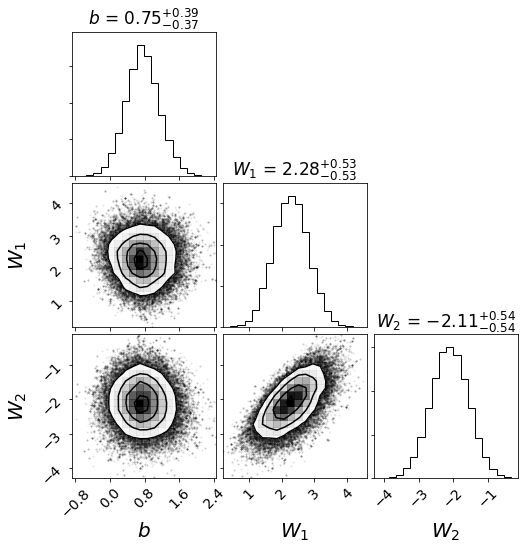

In [13]:
# Plot the weights with corner
fig_weights = corner.corner(samples, labels=[r'$b$', r'$W_1$', r'$W_2$'], label_kwargs={'fontsize': 20},
                            show_titles=True, title_kwargs={'fontsize': 17})

### Extract weights and bias pdf:s for the BNN

### Predict using the BNN for high, low and near critical temperatures

In [20]:
print(samples)

[[ 0.66720225  2.1218705  -1.50219309]
 [ 0.66939173  2.16576044 -1.40058719]
 [ 0.66939173  2.16576044 -1.40058719]
 ...
 [ 0.57588439  2.55599624 -2.25887238]
 [ 0.5723714   2.59217047 -2.28926193]
 [ 0.63533294  2.67645172 -2.0869988 ]]
